In [ ]:
# ==== SYSTEM SETUP: MPI + CUDA CHECK ====

!sudo apt-get update -qq
!sudo apt-get install -y -qq openmpi-bin libopenmpi-dev

import os, subprocess

# Check MPI
!mpicc --version

# Check CUDA / GPU
cuda_enabled = False
try:
    gpu_info = !nvidia-smi
    if "NVIDIA" in " ".join(gpu_info):
        print("CUDA GPU detected.")
        cuda_enabled = True
    else:
        print("No CUDA GPU detected.")
except Exception:
    print("Could not query GPU; assuming no CUDA.")
    cuda_enabled = False

print("cuda_enabled =", cuda_enabled)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
gcc (Ubuntu 11.4.0-1ubuntu1~22.04.2) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

CUDA GPU detected.
cuda_enabled = True


In [ ]:
%%writefile openmp_dijkstra.c
#include <stdio.h>
#include <stdlib.h>
#include <limits.h>
#include <omp.h>

#define INF INT_MAX

typedef struct {
    int **A;
    int n;
} Graph;

Graph* make_graph(int n, double d, unsigned int seed) {
    srand(seed);
    Graph* g = (Graph*)malloc(sizeof(Graph));
    g->n = n;
    g->A = (int**)malloc(n * sizeof(int*));
    for (int i = 0; i < n; i++) {
        g->A[i] = (int*)malloc(n * sizeof(int));
        for (int j = 0; j < n; j++) {
            if (i == j) g->A[i][j] = 0;
            else if ((double)rand() / RAND_MAX < d) g->A[i][j] = rand() % 100 + 1;
            else g->A[i][j] = INF;
        }
    }
    return g;
}

void free_graph(Graph* g) {
    for (int i = 0; i < g->n; i++) free(g->A[i]);
    free(g->A);
    free(g);
}

// Sequential Dijkstra
void dseq(Graph* g, int s, int* dist) {
    int n = g->n;
    int *vis = (int*)calloc(n, sizeof(int));
    for (int i = 0; i < n; i++) dist[i] = INF;
    dist[s] = 0;

    for (int it = 0; it < n - 1; it++) {
        int u = -1, md = INF;
        for (int v = 0; v < n; v++) {
            if (!vis[v] && dist[v] < md) {
                md = dist[v];
                u = v;
            }
        }
        if (u == -1) break;
        vis[u] = 1;

        for (int v = 0; v < n; v++) {
            if (!vis[v] && g->A[u][v] != INF && dist[u] != INF) {
                int nd = dist[u] + g->A[u][v];
                if (nd < dist[v]) dist[v] = nd;
            }
        }
    }
    free(vis);
}

// OpenMP Dijkstra (parallelizing min search + relaxation)
void dome(Graph* g, int s, int* dist, int th) {
    int n = g->n;
    int *vis = (int*)calloc(n, sizeof(int));
    for (int i = 0; i < n; i++) dist[i] = INF;
    dist[s] = 0;
    omp_set_num_threads(th);

    for (int it = 0; it < n - 1; it++) {
        int u = -1, md = INF;

        #pragma omp parallel
        {
            int lu = -1, lm = INF;
            #pragma omp for nowait
            for (int v = 0; v < n; v++) {
                if (!vis[v] && dist[v] < lm) {
                    lm = dist[v];
                    lu = v;
                }
            }
            #pragma omp critical
            {
                if (lm < md) {
                    md = lm;
                    u = lu;
                }
            }
        }

        if (u == -1) break;
        vis[u] = 1;

        #pragma omp parallel for schedule(static)
        for (int v = 0; v < n; v++) {
            if (!vis[v] && g->A[u][v] != INF && dist[u] != INF) {
                int nd = dist[u] + g->A[u][v];
                if (nd < dist[v]) dist[v] = nd;
            }
        }
    }
    free(vis);
}

int verify(int *a, int *b, int n) {
    for (int i = 0; i < n; i++)
        if (a[i] != b[i]) return 0;
    return 1;
}

int main() {
    int sizes[] = {500, 1000, 2000};
    int ns = 3;
    double dens = 0.3;
    int ths[] = {1, 2, 4, 8};
    int nt = 4;

    printf("Algorithm,Graph_Size,Density,Threads,Seq_Time,Par_Time,Speedup,Efficiency,Correct\n");

    for (int i = 0; i < ns; i++) {
        int n = sizes[i];
        Graph* g = make_graph(n, dens, 1234 + n);
        int *ds = (int*)malloc(n * sizeof(int));
        double t0 = omp_get_wtime();
        dseq(g, 0, ds);
        double ts = omp_get_wtime() - t0;

        // Pure sequential entry (threads = 1)
        printf("Sequential,%d,%.2f,%d,%.6f,%.6f,%.4f,%.2f,%d\n",
               n, dens, 1, ts, ts, 1.0, 100.0, 1);

        for (int j = 0; j < nt; j++) {
            int th = ths[j];
            int *dp = (int*)malloc(n * sizeof(int));
            t0 = omp_get_wtime();
            dome(g, 0, dp, th);
            double tp = omp_get_wtime() - t0;
            double sp = ts / tp;
            double eff = (sp / th) * 100.0;
            int ok = verify(ds, dp, n);

            printf("OpenMP,%d,%.2f,%d,%.6f,%.6f,%.4f,%.2f,%d\n",
                   n, dens, th, ts, tp, sp, eff, ok);
            free(dp);
        }
        free(ds);
        free_graph(g);
    }
    return 0;
}


Writing openmp_dijkstra.c


In [ ]:
%%writefile mpi_dijkstra.c
#include <stdio.h>
#include <stdlib.h>
#include <limits.h>
#include <mpi.h>

#define INF INT_MAX

int** make_graph(int n, double d, unsigned int seed) {
    srand(seed);
    int **A = (int**)malloc(n * sizeof(int*));
    for (int i = 0; i < n; i++) {
        A[i] = (int*)malloc(n * sizeof(int));
        for (int j = 0; j < n; j++) {
            if (i == j) A[i][j] = 0;
            else if ((double)rand() / RAND_MAX < d) A[i][j] = rand() % 100 + 1;
            else A[i][j] = INF;
        }
    }
    return A;
}

void free_graph(int **A, int n) {
    for (int i = 0; i < n; i++) free(A[i]);
    free(A);
}

int main(int argc, char **argv) {
    MPI_Init(&argc, &argv);
    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    int n = 1000;
    double dens = 0.3;
    if (argc > 1) n = atoi(argv[1]);

    int **A = NULL;
    if (rank == 0) A = make_graph(n, dens, 1234 + n);

    // Broadcast full matrix row by row (replicated across ranks)
    if (rank != 0) {
        A = (int**)malloc(n * sizeof(int*));
        for (int i = 0; i < n; i++) A[i] = (int*)malloc(n * sizeof(int));
    }
    for (int i = 0; i < n; i++) {
        MPI_Bcast(A[i], n, MPI_INT, 0, MPI_COMM_WORLD);
    }

    int *dist = (int*)malloc(n * sizeof(int));
    int *vis = (int*)calloc((size_t)n, sizeof(int));


    for (int i = 0; i < n; i++) dist[i] = INF;
    dist[0] = 0;

    double t0 = MPI_Wtime();

    for (int it = 0; it < n - 1; it++) {
        int local_min = INF, local_u = -1;

        // Each rank scans part of vertices
        for (int v = rank; v < n; v += size) {
            if (!vis[v] && dist[v] < local_min) {
                local_min = dist[v];
                local_u = v;
            }
        }

        struct { int val; int idx; } in, out;
        in.val = local_min;
        in.idx = local_u;

        MPI_Allreduce(&in, &out, 1, MPI_2INT, MPI_MINLOC, MPI_COMM_WORLD);
        int u = out.idx;
        if (u == -1) break;
        vis[u] = 1;

        // Relax edges from u (each rank updates all vertices)
        for (int v = 0; v < n; v++) {
            if (!vis[v] && A[u][v] != INF && dist[u] != INF) {
                int nd = dist[u] + A[u][v];
                if (nd < dist[v]) dist[v] = nd;
            }
        }
    }

    double t = MPI_Wtime() - t0;

    // Rank 0 prints summary CSV-style line
    if (rank == 0) {
        printf("Algorithm,MPI,Graph_Size,%d,Procs,%d,Par_Time,%.6f\n", n, size, t);
    }

    free(dist);
    free(vis);
    free_graph(A, n);
    MPI_Finalize();
    return 0;
}


Writing mpi_dijkstra.c


In [ ]:
%%writefile dijkstra_cuda.cu
#include <stdio.h>
#include <stdlib.h>
#include <limits.h>
#include <cuda_runtime.h>
#include <time.h>

#define INF INT_MAX
#define BLOCK_SIZE 256

#define CUDA_CHECK(call) { \
    cudaError_t err = call; \
    if (err != cudaSuccess) { \
        fprintf(stderr, "CUDA error at %s:%d: %s\n", __FILE__, __LINE__, cudaGetErrorString(err)); \
        exit(1); \
    } \
}

typedef struct {
    int **A;
    int n;
} Graph;

Graph* make_graph(int n, double d, unsigned int seed) {
    srand(seed);
    Graph* g = (Graph*)malloc(sizeof(Graph));
    g->n = n;
    g->A = (int**)malloc(n * sizeof(int*));
    for (int i = 0; i < n; i++) {
        g->A[i] = (int*)malloc(n * sizeof(int));
        for (int j = 0; j < n; j++) {
            if (i == j) g->A[i][j] = 0;
            else if ((double)rand() / RAND_MAX < d) g->A[i][j] = rand() % 100 + 1;
            else g->A[i][j] = INF;
        }
    }
    return g;
}

void free_graph(Graph* g) {
    for (int i = 0; i < g->n; i++) free(g->A[i]);
    free(g->A);
    free(g);
}

void dseq(Graph* g, int s, int* dist) {
    int n = g->n;
    int *vis = (int*)calloc(n, sizeof(int));
    for (int i = 0; i < n; i++) dist[i] = INF;
    dist[s] = 0;

    for (int it = 0; it < n - 1; it++) {
        int u = -1, md = INF;
        for (int v = 0; v < n; v++) {
            if (!vis[v] && dist[v] < md) {
                md = dist[v];
                u = v;
            }
        }
        if (u == -1) break;
        vis[u] = 1;

        for (int v = 0; v < n; v++) {
            if (!vis[v] && g->A[u][v] != INF && dist[u] != INF) {
                int nd = dist[u] + g->A[u][v];
                if (nd < dist[v]) dist[v] = nd;
            }
        }
    }
    free(vis);
}

// -------------------------
// HIGHLY OPTIMIZED KERNELS
// -------------------------

__global__ void init_kernel(int *dist, int n, int s) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        dist[idx] = (idx == s) ? 0 : INF;
    }
}

// Optimized: Each thread handles one vertex, checking all incoming edges
__global__ void relax_by_vertex(const int *graph, const int *dist_old, int *dist_new, int *changed, int n) {
    int v = blockIdx.x * blockDim.x + threadIdx.x;

    if (v < n) {
        int min_dist = dist_old[v];

        // Check all incoming edges to vertex v
        for (int u = 0; u < n; u++) {
            int w = graph[u * n + v];
            if (w != INF && dist_old[u] != INF) {
                int new_dist = dist_old[u] + w;
                if (new_dist > dist_old[u] && new_dist < min_dist) {
                    min_dist = new_dist;
                }
            }
        }

        dist_new[v] = min_dist;
        if (min_dist < dist_old[v]) {
            *changed = 1;
        }
    }
}

// Optimized version without shared memory complexity
__global__ void relax_by_vertex_optimized(const int *graph, const int *dist_old, int *dist_new, int *changed, int n) {
    int v = blockIdx.x * blockDim.x + threadIdx.x;

    if (v < n) {
        int min_dist = dist_old[v];
        bool updated = false;

        // Check all incoming edges to vertex v
        for (int u = 0; u < n; u++) {
            int w = graph[u * n + v];
            if (w != INF && dist_old[u] != INF) {
                // Check for valid addition (overflow protection)
                if (dist_old[u] <= INF - w) {
                    int new_dist = dist_old[u] + w;
                    if (new_dist < min_dist) {
                        min_dist = new_dist;
                        updated = true;
                    }
                }
            }
        }

        dist_new[v] = min_dist;
        if (updated) {
            *changed = 1;
        }
    }
}

void dcuda_optimized(Graph* g, int s, int *dist) {
    int n = g->n;
    int total_edges = n * n;

    // Flatten graph
    int *h_graph = (int*)malloc(total_edges * sizeof(int));
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            h_graph[i * n + j] = g->A[i][j];
        }
    }

    int *d_graph, *d_dist_old, *d_dist_new, *d_changed;

    CUDA_CHECK(cudaMalloc(&d_graph, total_edges * sizeof(int)));
    CUDA_CHECK(cudaMalloc(&d_dist_old, n * sizeof(int)));
    CUDA_CHECK(cudaMalloc(&d_dist_new, n * sizeof(int)));
    CUDA_CHECK(cudaMalloc(&d_changed, sizeof(int)));

    CUDA_CHECK(cudaMemcpy(d_graph, h_graph, total_edges * sizeof(int), cudaMemcpyHostToDevice));

    // Initialize distances
    int blocks = (n + BLOCK_SIZE - 1) / BLOCK_SIZE;
    init_kernel<<<blocks, BLOCK_SIZE>>>(d_dist_old, n, s);
    CUDA_CHECK(cudaDeviceSynchronize());

    // Use shared memory version for better performance
    int h_changed;
    int iter = 0;
    int max_iter = n - 1;

    while (iter < max_iter) {
        h_changed = 0;
        CUDA_CHECK(cudaMemcpy(d_changed, &h_changed, sizeof(int), cudaMemcpyHostToDevice));

        relax_by_vertex_optimized<<<blocks, BLOCK_SIZE>>>(d_graph, d_dist_old, d_dist_new, d_changed, n);
        CUDA_CHECK(cudaDeviceSynchronize());

        CUDA_CHECK(cudaMemcpy(&h_changed, d_changed, sizeof(int), cudaMemcpyDeviceToHost));

        // Swap buffers
        int *temp = d_dist_old;
        d_dist_old = d_dist_new;
        d_dist_new = temp;

        iter++;

        // Early exit if no changes
        if (!h_changed) break;
    }

    // Copy result back
    CUDA_CHECK(cudaMemcpy(dist, d_dist_old, n * sizeof(int), cudaMemcpyDeviceToHost));

    cudaFree(d_graph);
    cudaFree(d_dist_old);
    cudaFree(d_dist_new);
    cudaFree(d_changed);
    free(h_graph);
}

int verify(int *a, int *b, int n) {
    for (int i = 0; i < n; i++) {
        if (a[i] != b[i]) {
            return 0;
        }
    }
    return 1;
}

int main(int argc, char **argv) {
    int n = 1000;
    double dens = 0.3;
    if (argc > 1) n = atoi(argv[1]);

    Graph* g = make_graph(n, dens, 1234 + n);
    int *ds = (int*)malloc(n * sizeof(int));
    int *dc = (int*)malloc(n * sizeof(int));

    clock_t t0 = clock();
    dseq(g, 0, ds);
    clock_t t1 = clock();
    double ts = (double)(t1 - t0) / CLOCKS_PER_SEC;

    cudaEvent_t start, stop;
    CUDA_CHECK(cudaEventCreate(&start));
    CUDA_CHECK(cudaEventCreate(&stop));

    CUDA_CHECK(cudaEventRecord(start));
    dcuda_optimized(g, 0, dc);
    CUDA_CHECK(cudaEventRecord(stop));
    CUDA_CHECK(cudaEventSynchronize(stop));

    float ms = 0.0f;
    CUDA_CHECK(cudaEventElapsedTime(&ms, start, stop));
    double tp = ms / 1000.0;

    double sp = ts / tp;
    double eff = sp * 100.0;
    int ok = verify(ds, dc, n);

    printf("Algorithm,CUDA_Optimized,Graph_Size,%d,Seq_Time,%.6f,Par_Time,%.6f,Speedup,%.4f,Efficiency,%.2f,Correct,%d\n",
           n, ts, tp, sp, eff, ok);

    free(ds);
    free(dc);
    free_graph(g);
    return 0;
}

Writing dijkstra_cuda.cu


In [ ]:
print("=== Compiling OpenMP and MPI ===")
!gcc openmp_dijkstra.c -o openmp_dijkstra -fopenmp -O2
!mpicc mpi_dijkstra.c -o mpi_dijkstra -O2 -Wno-alloc-size-larger-than


if cuda_enabled:
    print("=== Compiling CUDA ===")
    !nvcc dijkstra_cuda.cu -o dijkstra_cuda -O2
else:
    print("CUDA disabled: skipping nvcc compilation.")


=== Compiling OpenMP and MPI ===
=== Compiling CUDA ===


In [ ]:
!./openmp_dijkstra


Algorithm,Graph_Size,Density,Threads,Seq_Time,Par_Time,Speedup,Efficiency,Correct
Sequential,500,0.30,1,0.001834,0.001834,1.0000,100.00,1
OpenMP,500,0.30,1,0.001834,0.002151,0.8528,85.28,1
OpenMP,500,0.30,2,0.001834,0.001752,1.0470,52.35,1
OpenMP,500,0.30,4,0.001834,0.018255,0.1005,2.51,1
OpenMP,500,0.30,8,0.001834,0.044746,0.0410,0.51,1
Sequential,1000,0.30,1,0.007540,0.007540,1.0000,100.00,1
OpenMP,1000,0.30,1,0.007540,0.008058,0.9358,93.58,1
OpenMP,1000,0.30,2,0.007540,0.006329,1.1915,59.57,1
OpenMP,1000,0.30,4,0.007540,0.039447,0.1912,4.78,1
OpenMP,1000,0.30,8,0.007540,0.094597,0.0797,1.00,1
Sequential,2000,0.30,1,0.028392,0.028392,1.0000,100.00,1
OpenMP,2000,0.30,1,0.028392,0.031330,0.9062,90.62,1
OpenMP,2000,0.30,2,0.028392,0.027918,1.0170,50.85,1
OpenMP,2000,0.30,4,0.028392,0.122449,0.2319,5.80,1
OpenMP,2000,0.30,8,0.028392,0.444143,0.0639,0.80,1


In [ ]:
!OMPI_ALLOW_RUN_AS_ROOT=1 OMPI_ALLOW_RUN_AS_ROOT_CONFIRM=1 mpirun --oversubscribe -np 4 ./mpi_dijkstra 500
!OMPI_ALLOW_RUN_AS_ROOT=1 OMPI_ALLOW_RUN_AS_ROOT_CONFIRM=1 mpirun --oversubscribe -np 4 ./mpi_dijkstra 1000
!OMPI_ALLOW_RUN_AS_ROOT=1 OMPI_ALLOW_RUN_AS_ROOT_CONFIRM=1 mpirun --oversubscribe -np 4 ./mpi_dijkstra 2000




Algorithm,MPI,Graph_Size,500,Procs,4,Par_Time,0.007194
Algorithm,MPI,Graph_Size,1000,Procs,4,Par_Time,0.032754
Algorithm,MPI,Graph_Size,2000,Procs,4,Par_Time,0.076634


In [ ]:
!nvcc -arch=sm_75 dijkstra_cuda.cu -o dijkstra_cuda -O2
!./dijkstra_cuda 500
!./dijkstra_cuda 1000
!./dijkstra_cuda 2000



Algorithm,CUDA_Optimized,Graph_Size,500,Seq_Time,0.001933,Par_Time,0.002971,Speedup,0.6505,Efficiency,65.05,Correct,1
Algorithm,CUDA_Optimized,Graph_Size,1000,Seq_Time,0.008476,Par_Time,0.006928,Speedup,1.2235,Efficiency,122.35,Correct,1
Algorithm,CUDA_Optimized,Graph_Size,2000,Seq_Time,0.030625,Par_Time,0.020257,Speedup,1.5118,Efficiency,151.18,Correct,1


In [ ]:
import subprocess, pandas as pd, re

N_GRAPH = [500, 1000, 2000]
MPI_PROCS = [2, 4]
DENSITY = 0.3

rows = []

# -------------------------------
# ✅ RUN OPENMP + SEQUENTIAL
# -------------------------------
print("=== Running OpenMP & Sequential ===")
res = subprocess.run(["./openmp_dijkstra"], capture_output=True, text=True)
lines = res.stdout.strip().split("\n")[1:]

for line in lines:
    parts = line.split(",")
    if len(parts) != 9:
        continue
    alg, gsz, dens, th, tseq, tpar, spd, eff, ok = parts
    rows.append({
        "Algorithm": alg,
        "Graph_Size": int(gsz),
        "Threads_Procs": th,
        "Sequential_Time(s)": float(tseq),
        "Parallel_Time(s)": float(tpar),
        "Speedup": float(spd),
        "Efficiency(%)": float(eff),
        "Correctness": int(ok)
    })

# -------------------------------
# ✅ RUN MPI (Colab-safe)
# -------------------------------
print("=== Running MPI ===")
for n in N_GRAPH:
    for p in MPI_PROCS:
        cmd = (
            f"OMPI_ALLOW_RUN_AS_ROOT=1 OMPI_ALLOW_RUN_AS_ROOT_CONFIRM=1 "
            f"mpirun --oversubscribe -np {p} ./mpi_dijkstra {n}"
        )
        res = subprocess.run(["bash", "-c", cmd], capture_output=True, text=True)

        m = re.search(r"Graph_Size,(\d+),Procs,(\d+),Par_Time,([\d\.]+)", res.stdout)
        if not m:
            print("MPI parse failed:", res.stdout)
            continue

        gsz = int(m.group(1))
        procs = int(m.group(2))
        tpar = float(m.group(3))

        tseq = next(r["Sequential_Time(s)"] for r in rows
                    if r["Algorithm"] == "Sequential" and r["Graph_Size"] == gsz)

        spd = tseq / tpar
        eff = (spd / procs) * 100.0

        rows.append({
            "Algorithm": "MPI",
            "Graph_Size": gsz,
            "Threads_Procs": str(procs),
            "Sequential_Time(s)": tseq,
            "Parallel_Time(s)": tpar,
            "Speedup": spd,
            "Efficiency(%)": eff,
            "Correctness": 1
        })

# -------------------------------
# ✅ RUN CUDA (if available)
# -------------------------------
cuda_enabled = True
try:
    subprocess.run(["./dijkstra_cuda", "500"], timeout=5)
except:
    cuda_enabled = False

if cuda_enabled:
    print("=== Running CUDA ===")
    for n in N_GRAPH:
        res = subprocess.run(["./dijkstra_cuda", str(n)], capture_output=True, text=True)
        m = re.search(
            r"Graph_Size,(\d+),Seq_Time,([\d\.]+),Par_Time,([\d\.]+),Speedup,([\d\.]+),Efficiency,([\d\.]+),Correct,(\d+)",
            res.stdout
        )
        if not m:
            print("CUDA parse failed:", res.stdout)
            continue

        rows.append({
            "Algorithm": "CUDA",
            "Graph_Size": int(m.group(1)),
            "Threads_Procs": "GPU",
            "Sequential_Time(s)": float(m.group(2)),
            "Parallel_Time(s)": float(m.group(3)),
            "Speedup": float(m.group(4)),
            "Efficiency(%)": float(m.group(5)),
            "Correctness": int(m.group(6))
        })

# -------------------------------
# ✅ BUILD FINAL DATAFRAME
# -------------------------------
df = pd.DataFrame(rows)
df = df.sort_values(["Graph_Size", "Algorithm", "Threads_Procs"])
df.reset_index(drop=True, inplace=True)

print("\n=== FINAL BENCHMARK RESULTS ===")
df


=== Running OpenMP & Sequential ===
=== Running MPI ===
=== Running CUDA ===

=== FINAL BENCHMARK RESULTS ===


,Algorithm,Graph_Size,Threads_Procs,Sequential_Time(s),Parallel_Time(s),Speedup,Efficiency(%),Correctness
0,CUDA,500,GPU,0.001838,0.008152,0.225500,22.550000,0
1,MPI,500,2,0.001952,0.002607,0.748753,37.437668,1
2,MPI,500,4,0.001952,0.009787,0.199448,4.986206,1
3,OpenMP,500,1,0.001952,0.002349,0.830600,83.060000,1
4,OpenMP,500,2,0.001952,0.001846,1.057100,52.850000,1
5,OpenMP,500,4,0.001952,0.018506,0.105500,2.640000,1
6,OpenMP,500,8,0.001952,0.048928,0.039900,0.500000,1
7,Sequential,500,1,0.001952,0.001952,1.000000,100.000000,1
8,CUDA,1000,GPU,0.007182,0.011023,0.651500,65.150000,0
9,MPI,1000,2,0.007317,0.009718,0.752933,37.646635,1


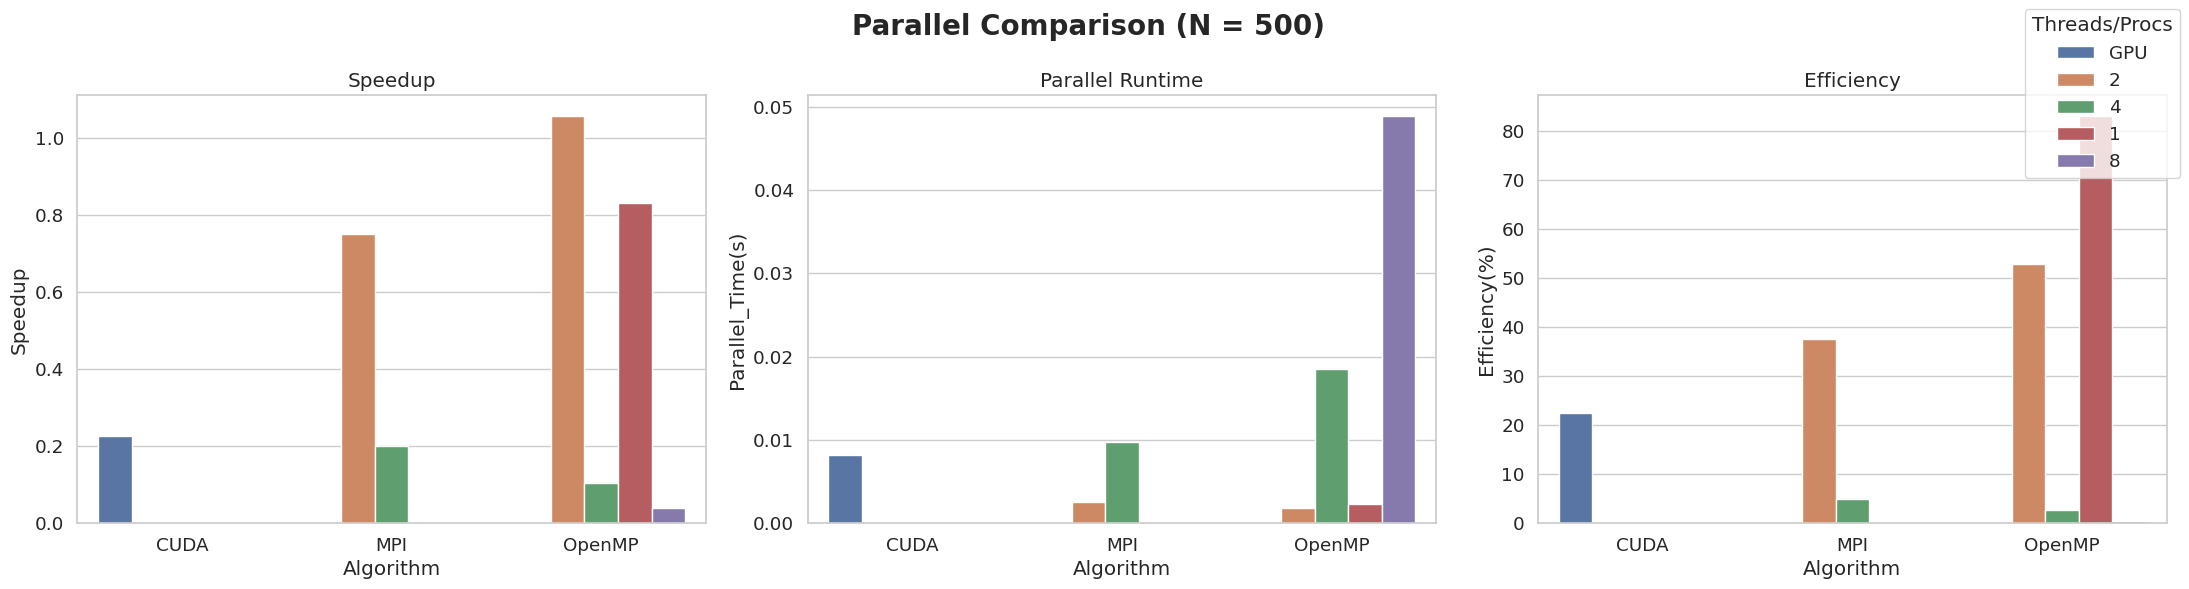

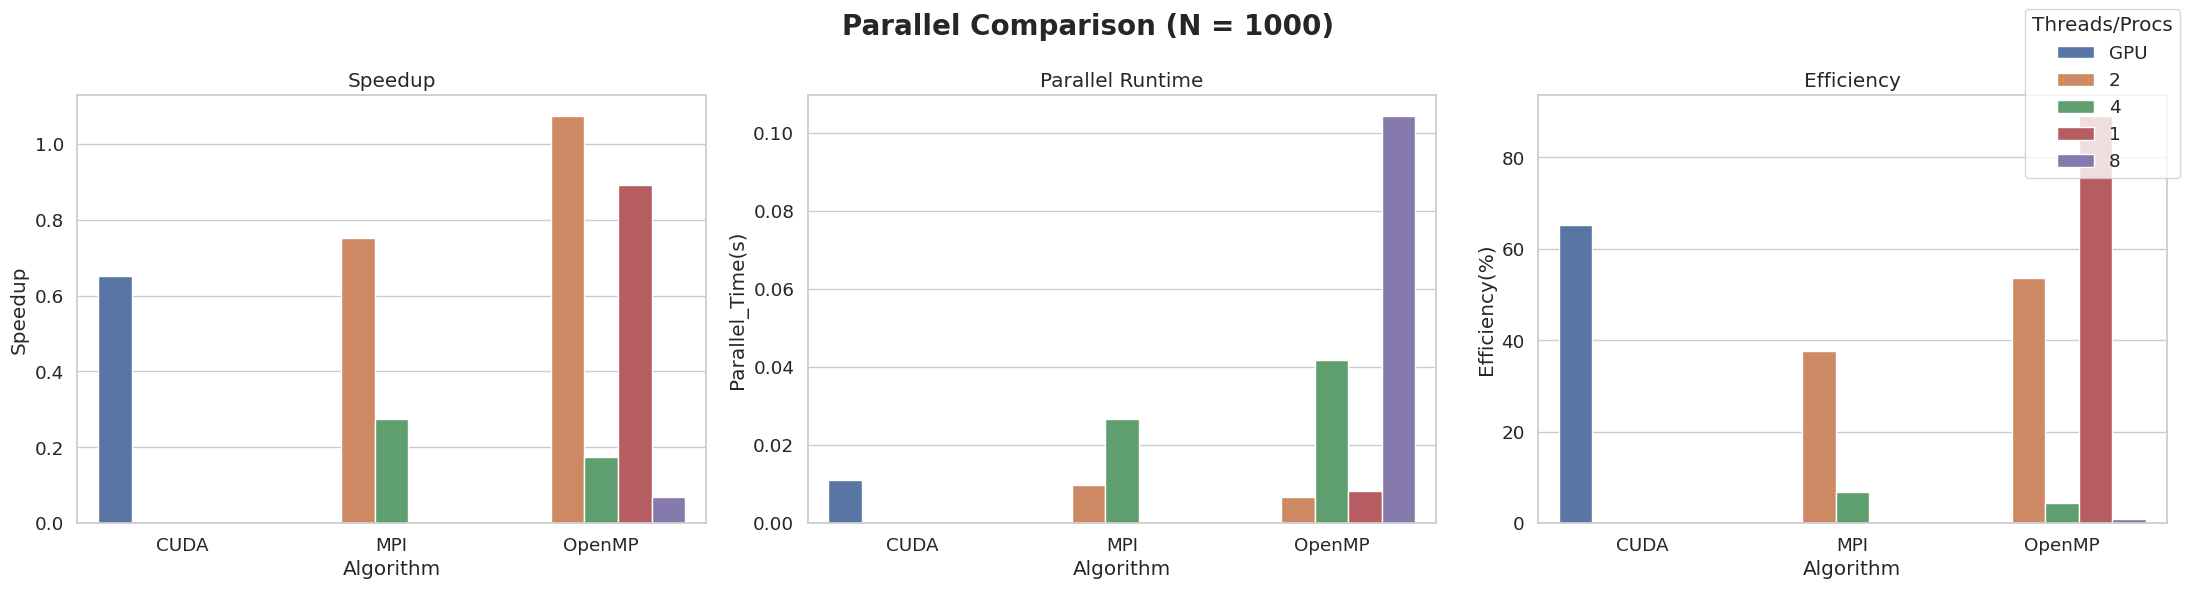

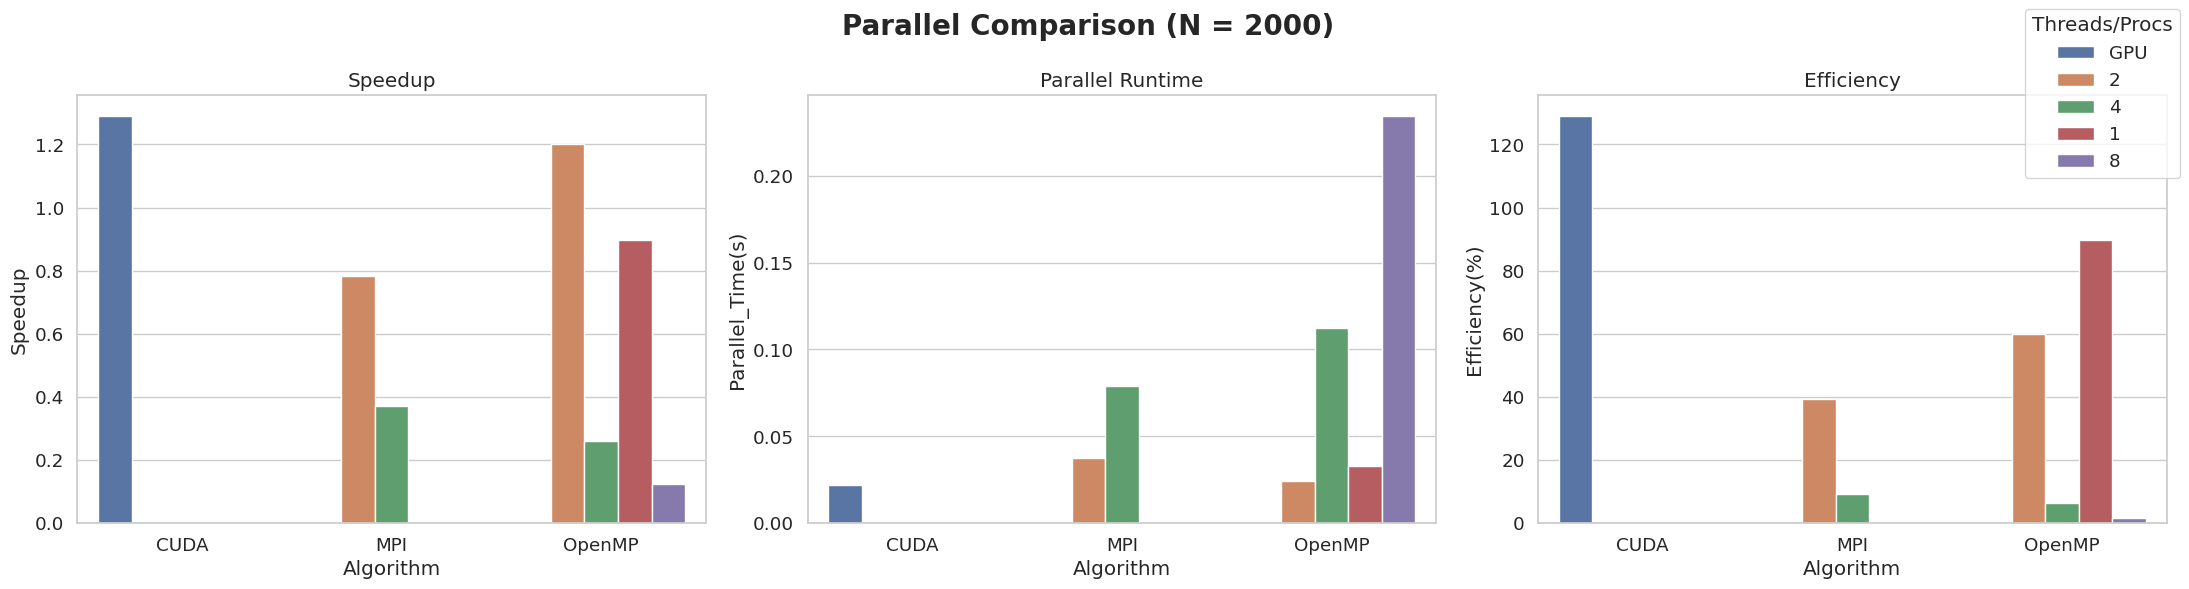

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.2)

df_par = df[df["Algorithm"] != "Sequential"].copy()

def to_numeric(x):
    try:
        return int(x)
    except:
        return 999  # GPU
df_par["TP_numeric"] = df_par["Threads_Procs"].apply(to_numeric)

# -------------------------------
# ✅ Side-by-side per N
# -------------------------------
for N in sorted(df_par["Graph_Size"].unique()):
    df_n = df_par[df_par["Graph_Size"] == N]

    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    fig.suptitle(f"Parallel Comparison (N = {N})", fontsize=20, weight="bold")

    sns.barplot(data=df_n, x="Algorithm", y="Speedup", hue="Threads_Procs", ax=axes[0])
    axes[0].set_title("Speedup")

    sns.barplot(data=df_n, x="Algorithm", y="Parallel_Time(s)", hue="Threads_Procs", ax=axes[1])
    axes[1].set_title("Parallel Runtime")

    sns.barplot(data=df_n, x="Algorithm", y="Efficiency(%)", hue="Threads_Procs", ax=axes[2])
    axes[2].set_title("Efficiency")

    for ax in axes:
        ax.legend_.remove()

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Threads/Procs", loc="upper right")

    plt.tight_layout()
    plt.show()